In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path

from shapely import affinity
from shapely.geometry.multipolygon import MultiPolygon
from scipy.spatial import Voronoi

In [2]:
weight_wind = [
    0.057, #landuse
    0.044, #slope
    0.088, #elevation
    0.071, #d to settlement
    0.044, #d to wetland
    0.055, #d to forest
    0.044, #prox to road
    0.088, #prox to sub
    0.261, #Resource quality
    0.247 #Farm Required area
    ]
print(sum(weight_wind))

weight_solar = [
    0.140, #landuse
    0.126, #slope
    0.063, #elevation
    0.057, #d to settlement
    0.0495, #d to wetland
    0.0275, #d to forest
    0.047, #prox to road
    0.099, #prox to sub
    0.254, #Resource quality
    0.135 #Farm Required area
    ]
print(sum(weight_solar))

0.999
0.998


In [3]:
## Create teh final SI map template ###
xr_final_SI = xr.open_dataset('Output\\xr_SI_Landcover.nc')
xr_final_SI = xr_final_SI.drop_vars('lccs_class')
xr_final_SI = xr_final_SI.drop_vars('SI_BGEC')
xr_final_SI = xr_final_SI.drop_vars('SI_Biomass')
xr_final_SI = xr_final_SI.drop_vars('SI_BGWW')
xr_final_SI = xr_final_SI.drop_vars('SI_MSW')
xr_final_SI = xr_final_SI.drop_vars('SI_IEW')
xr_final_SI = xr_final_SI.drop_vars('aux')
xr_final_SI = xr_final_SI.drop_vars('distance')

xr_final_SI['AVA_Wind'] = xr_final_SI['SI_Wind']
xr_final_SI['AVA_Solar'] = xr_final_SI['SI_Solar']

xr_final_SI['SI_Wind'] = 0.0
xr_final_SI['SI_Solar'] = 0.0
xr_final_SI['AVA_Wind'] = 0.0
xr_final_SI['AVA_Solar'] = 0.0
print(xr_final_SI)
check_weight_wind = 0
check_weight_solar = 0

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   float64 0.0
    SI_Wind    float64 0.0
    AVA_Wind   float64 0.0
    AVA_Solar  float64 0.0


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.057
check w solar =  0.14
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(148914.99)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(148914.99)


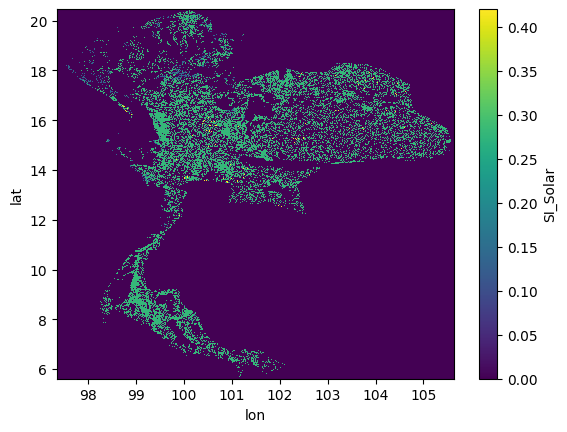

In [4]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_Landcover.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_landuse_suitability_index['SI_Wind'] * weight_wind[0])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_landuse_suitability_index['SI_Solar'] * weight_solar[0])
xr_final_SI['AVA_Wind'] = xr.where(xr_landuse_suitability_index['SI_Wind'] > 0 ,0.09,0)
xr_final_SI['AVA_Solar'] = xr.where(xr_landuse_suitability_index['SI_Solar'] > 0 ,0.09,0)

print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[0]
check_weight_solar = check_weight_solar + weight_solar[0]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

In [5]:
xr_cal = xr.open_dataset('Output\\xr_SI_Slope.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[1])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[1])

# cutout area for slope 
xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[1]
check_weight_solar = check_weight_solar + weight_solar[1]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.101
check w solar =  0.266
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(142577.37)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(123109.92)


In [6]:
xr_cal = xr.open_dataset('Output\\xr_SI_Elevation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[2])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[2])
## NO Cutout area for elevation 
# xr_final_SI['AVA_Wind'] = xr.where( xr_cal['suitability_index'] == 0 ,0,xr_final_SI['AVA_Wind'])
# xr_final_SI['AVA_Solar'] = xr.where( xr_cal['suitability_index'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[2]
check_weight_solar = check_weight_solar + weight_solar[2]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.189
check w solar =  0.329
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(142577.37)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(123109.92)


In [7]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosettlementarea.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[3])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[3])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[3]
check_weight_solar = check_weight_solar + weight_solar[3]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.26
check w solar =  0.386
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(134858.97)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(115525.71)


In [8]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetowetland.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[4])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[4])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[4]
check_weight_solar = check_weight_solar + weight_solar[4]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.304
check w solar =  0.4355
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(131209.2)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(112024.44)


In [9]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoforest.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[5])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[5])

xr_final_SI['AVA_Wind'] = xr.where( xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where( xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[5]
check_weight_solar = check_weight_solar + weight_solar[5]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.359
check w solar =  0.463
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86647.59)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90427.5)


In [10]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetoroad.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[6])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[6])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[6]
check_weight_solar = check_weight_solar + weight_solar[6]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.40299999999999997
check w solar =  0.51
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86268.78)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90047.61)


In [11]:
xr_cal = xr.open_dataset('Output\\xr_SI_Distancetosubstation.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[7])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[7])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar'] == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[7]
check_weight_solar = check_weight_solar + weight_solar[7]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.491
check w solar =  0.609
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86268.78)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90047.61)


<xarray.Dataset>
Dimensions:    (lat: 5346, lon: 2985)
Coordinates:
  * lat        (lat) float64 5.615 5.618 5.621 5.624 ... 20.45 20.46 20.46 20.46
  * lon        (lon) float64 97.35 97.35 97.35 97.35 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Check w wind =  0.752
check w solar =  0.863
AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(86264.34, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(90046.14, dtype=float32)


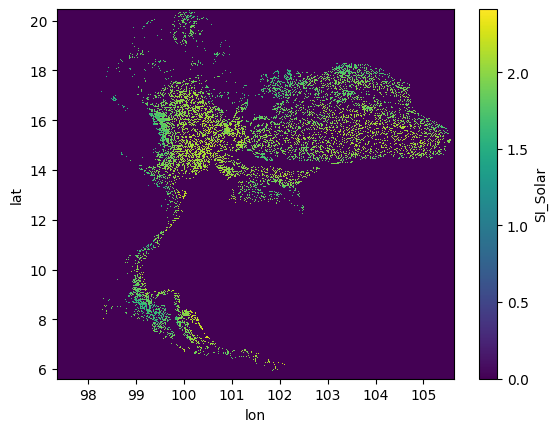

In [12]:
xr_cal = xr.open_dataset('Output\\xr_SI_resourcepotential.nc')

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'] + (xr_cal['SI_Wind'] * weight_wind[8])
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'] + (xr_cal['SI_Solar'] * weight_solar[8])

xr_final_SI['AVA_Wind'] = xr.where(xr_cal['SI_Wind'] == 0 ,0,xr_final_SI['AVA_Wind'])
xr_final_SI['AVA_Solar'] = xr.where(xr_cal['SI_Solar']  == 0 ,0,xr_final_SI['AVA_Solar'])

xr_final_SI['SI_Wind'] = xr_final_SI['SI_Wind'].astype('float32')
xr_final_SI['SI_Solar'] = xr_final_SI['SI_Solar'].astype('float32')
xr_final_SI['AVA_Wind'] = xr_final_SI['AVA_Wind'].astype('float32')
xr_final_SI['AVA_Solar'] = xr_final_SI['AVA_Solar'].astype('float32')

xr_final_SI['SI_Wind'] = xr.where( xr_final_SI['AVA_Wind'] == 0 ,0,xr_final_SI['SI_Wind'])
xr_final_SI['SI_Solar'] = xr.where( xr_final_SI['AVA_Solar'] == 0 ,0,xr_final_SI['SI_Solar'])
print(xr_final_SI)

check_weight_wind = check_weight_wind + weight_wind[8]
check_weight_solar = check_weight_solar + weight_solar[8]
print("Check w wind = ",check_weight_wind)
print("check w solar = ",check_weight_solar)
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

xr_final_SI['SI_Solar'].plot()

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\EGAT\AppData\Local\Temp\ipykernel_39644\2922164285.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  existingplants['area'] = existingplants['geometry'].buffer(0.05)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis o

AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(70533.664, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(73742.92, dtype=float32)


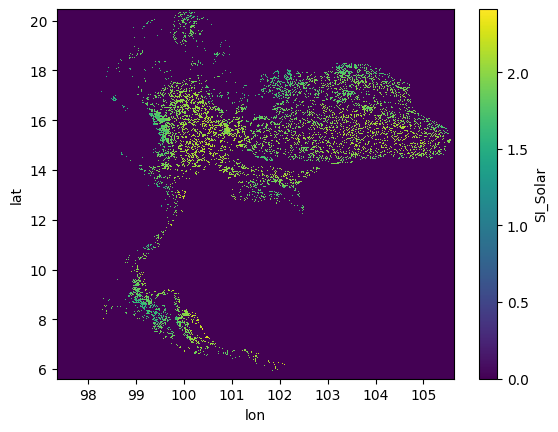

In [13]:
### First, I exclude existing plant and RE Biglot #### 
existingplants = pd.read_csv("Data\\ExistingPlants_wPosition.csv")
existingplants = gpd.GeoDataFrame(existingplants, geometry =gpd.points_from_xy(existingplants['longitude'],existingplants['latitude']))
existingplants.crs = {'init': 'epsg:4326'}
# existingplants = existingplants.loc[existingplants['EXP_MW'] >= 1]
existingplants.reset_index(inplace=True,drop=True)
        
for i in existingplants.columns:
    if i not in ['Sale_MW','FuelTypeName','latitude','longitude','geometry']:
        existingplants = existingplants.drop(columns=i)

existingplants['area'] = existingplants['geometry'].buffer(0.05)

REbiglot = pd.read_excel('Data\\NewVRE.xlsx',sheet_name='สรุปผู้ที่ได้รับการคัดเลือก')
REbiglot = gpd.GeoDataFrame(REbiglot, geometry =gpd.points_from_xy(REbiglot['lon'],REbiglot['lat']))
REbiglot.crs = {'init': 'epsg:4326'}
REbiglot.reset_index(inplace=True,drop=True)

REbiglot['area'] = REbiglot['geometry'].buffer(0.05)

df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI['aux'] = 1

for i in range(len(existingplants)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(existingplants['area'][i]))] = 0

for i in range(len(REbiglot)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(REbiglot['area'][i]))] = 0

df_final_SI['SI_Wind'] = df_final_SI['SI_Wind'] * df_final_SI['aux']
df_final_SI['SI_Solar'] = df_final_SI['SI_Solar'] * df_final_SI['aux']
df_final_SI['AVA_Wind'] = df_final_SI['AVA_Wind'] * df_final_SI['aux']
df_final_SI['AVA_Solar'] = df_final_SI['AVA_Solar'] * df_final_SI['aux']

df_final_SI = df_final_SI.drop(columns=['aux','geometry'])
df_final_SI = df_final_SI.set_index(['lat', 'lon'])
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI)

print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())
xr_final_SI['SI_Solar'].plot()

In [15]:
xr_final_SI['AVA_Wind'].to_netcdf(path='Output_SolarWind\\xr_AVA_Wind.nc')
xr_final_SI['AVA_Solar'].to_netcdf(path='Output_SolarWind\\xr_AVA_Solar.nc')

In [16]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

## max capacity of spp 90 MW
maxcapacityinpolygon = 90

maxarea_wind = 90/mwperkm2_wind
maxarea_solar= 90/mwperkm2_solar

print("maxarea_wind = ",maxarea_wind)
print("maxarea_solar = ",maxarea_solar)

from shapely.geometry import Polygon
from shapely.prepared import prep

def grid_bounds(geom, delta):
    minx, miny, maxx, maxy = geom.bounds
    nx = int((maxx - minx)/delta)
    ny = int((maxy - miny)/delta)
    gx, gy = np.linspace(minx,maxx,nx), np.linspace(miny,maxy,ny)
    grid = []
    for i in range(len(gx)-1):
        for j in range(len(gy)-1):
            poly_ij = Polygon([[gx[i],gy[j]],[gx[i],gy[j+1]],[gx[i+1],gy[j+1]],[gx[i+1],gy[j]]])
            grid.append( poly_ij )
    return grid

def partition(geom, delta):
    prepared_geom = prep(geom)
    grid = list(filter(prepared_geom.intersects, grid_bounds(geom, delta)))
    return grid

maxarea_wind =  20.0
maxarea_solar =  6.0


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

len of polygons =  8694


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


total area for wind =  65194.891300275216
Check w wind =  0.999
      pol_id_wind                                           geometry  \
0               0  POLYGON ((100.10833 20.41667, 100.11944 20.416...   
1               1  POLYGON ((99.99167 20.36944, 99.99444 20.36944...   
2               2  POLYGON ((99.99167 20.33611, 99.99444 20.33611...   
3               3  POLYGON ((99.89167 20.31944, 99.90556 20.31944...   
4               4  POLYGON ((100.03611 20.34167, 100.05000 20.341...   
...           ...                                                ...   
8689         8689  POLYGON ((100.75139 6.66667, 100.75139 6.68889...   
8690         8690  POLYGON ((100.75139 6.68889, 100.75139 6.71111...   
8691         8691  POLYGON ((100.77569 6.68889, 100.77569 6.71111...   
8692         8692  POLYGON ((101.44444 6.48056, 101.44444 6.50648...   
8693         8693  POLYGON ((101.49630 6.53241, 101.49630 6.55833...   

      raster_val       area                      center  final_SI_Wind 

<Axes: >

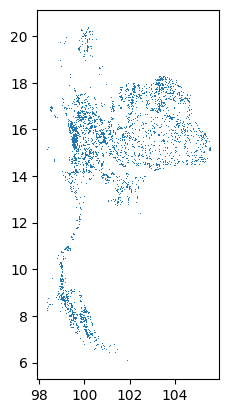

In [17]:
### Polygonized wind ### 

mask = None
with rasterio.Env():
    with rasterio.open('Output_SolarWind\\xr_AVA_Wind.nc') as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform,connectivity=8)))
        
geoms = list(results)

gpd_polygonized_raster_wind  = gpd.GeoDataFrame.from_features(geoms)
gpd_polygonized_raster_wind.crs = {'init': 'epsg:4326'}
gpd_polygonized_raster_wind= gpd_polygonized_raster_wind.to_crs({'init': 'epsg:3857'})
gpd_polygonized_raster_wind['area'] = gpd_polygonized_raster_wind['geometry'].area / (10**6)
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind.to_crs({'init': 'epsg:4326'})
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind.loc[gpd_polygonized_raster_wind['raster_val'] != 0]
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind.loc[gpd_polygonized_raster_wind['area'] > 4]

gpd_polygonized_raster_wind_normal = gpd_polygonized_raster_wind.loc[gpd_polygonized_raster_wind['area'] <= maxarea_wind]
gpd_polygonized_raster_wind_normal.reset_index(inplace=True,drop=True)
gpd_polygonized_raster_wind_large = gpd_polygonized_raster_wind.loc[gpd_polygonized_raster_wind['area'] > maxarea_wind]
gpd_polygonized_raster_wind_large.reset_index(inplace=True,drop=True)

geom = (gpd_polygonized_raster_wind_large['geometry'][0])
slicingsclae = 0.0175
grid = partition(geom, slicingsclae)

buffer = [shapely.geometry.Polygon(poly) for poly in (grid)]

gpd_ref  = gpd.GeoDataFrame(geometry=buffer)
gpd_ref.crs = {'init': 'epsg:4326'}
gpd_ref['center'] = gpd_ref['geometry'].centroid
gpd_ref = gpd_ref.loc[gpd_ref['center'].within(geom)]
gpd_ref.reset_index(inplace=True,drop=True)

for i in range(1,len(gpd_polygonized_raster_wind_large),1):
    geom = (gpd_polygonized_raster_wind_large['geometry'][i])
    grid = partition(geom, slicingsclae)
    buffer = [shapely.geometry.Polygon(poly) for poly in (grid)]
    gpd_buffer  = gpd.GeoDataFrame(geometry=buffer)
    gpd_buffer.crs = {'init': 'epsg:4326'}
    gpd_buffer['center'] = gpd_buffer['geometry'].centroid
    gpd_buffer = gpd_buffer.loc[gpd_buffer['center'].within(geom)]
    gpd_buffer.reset_index(inplace=True,drop=True)
    gpd_ref = gpd_ref.append(gpd_buffer)
    gpd_ref.reset_index(inplace=True,drop=True)


gpd_ref['raster_val'] = 0.09
gpd_ref= gpd_ref.to_crs({'init': 'epsg:3857'})
gpd_ref['area'] = gpd_ref['geometry'].area / (10**6)
gpd_ref= gpd_ref.to_crs({'init': 'epsg:4326'})
gpd_ref = gpd_ref.drop(columns='center')
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind_normal.append(gpd_ref)
gpd_polygonized_raster_wind.reset_index(inplace=True,drop=True)

gpd_polygonized_raster_wind['raster_val'] = 0
gpd_polygonized_raster_wind['raster_val'].loc[gpd_polygonized_raster_wind['area'] < 4] = 0
gpd_polygonized_raster_wind['raster_val'].loc[gpd_polygonized_raster_wind['area'] >= 4] = 3
gpd_polygonized_raster_wind['center'] = gpd_polygonized_raster_wind['geometry'].centroid
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind.reset_index()
gpd_polygonized_raster_wind = gpd_polygonized_raster_wind.rename(columns={'index':'pol_id_wind'})
print('len of polygons = ', len(gpd_polygonized_raster_wind))

df_xr_final_SI = xr_final_SI['SI_Wind'].to_dataframe()
df_xr_final_SI = df_xr_final_SI.loc[df_xr_final_SI['SI_Wind'] >0]
df_xr_final_SI.reset_index(inplace=True)
df_xr_final_SI = gpd.GeoDataFrame(df_xr_final_SI, geometry =gpd.points_from_xy(df_xr_final_SI['lon'],df_xr_final_SI['lat']))
df_xr_final_SI.crs = {'init': 'epsg:4326'}
df_ref = gpd.sjoin_nearest(df_xr_final_SI,gpd_polygonized_raster_wind,distance_col="distance",how='left')
df_ref= df_ref.drop(columns = ['geometry','index_right','raster_val','area','center','distance','lat','lon'])
df_ref = df_ref.groupby(['pol_id_wind']).agg('mean')

gpd_polygonized_raster_wind['final_SI_Wind'] = (gpd_polygonized_raster_wind['raster_val'] * weight_wind[9]) + df_ref['SI_Wind']
check_weight_wind = check_weight_wind + weight_wind[9]

print('total area for wind = ',gpd_polygonized_raster_wind['area'].sum())
print("Check w wind = ",check_weight_wind)
print(gpd_polygonized_raster_wind)
gpd_polygonized_raster_wind.to_csv('Output_SolarWind\\df_final_SI_Wind.csv',index=False)
gpd_polygonized_raster_wind.plot()


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<a

len of polygons =  17551


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


total area for solar =  79352.16454778601
Check w solar =  0.998
       pol_id_solar                                           geometry  \
0                 0  POLYGON ((100.10833 20.41667, 100.11944 20.416...   
1                 1  POLYGON ((100.07500 20.40278, 100.07778 20.402...   
2                 2  POLYGON ((100.10833 20.37500, 100.11111 20.375...   
3                 3  POLYGON ((99.95833 20.35556, 99.96111 20.35556...   
4                 4  POLYGON ((100.03889 20.34167, 100.03889 20.338...   
...             ...                                                ...   
17546         17546  POLYGON ((101.46111 6.42222, 101.46111 6.46944...   
17547         17547  POLYGON ((101.46111 6.34444, 101.46111 6.37222...   
17548         17548  POLYGON ((101.46111 6.37222, 101.46111 6.40000...   
17549         17549  POLYGON ((101.91667 6.30000, 101.91667 6.34722...   
17550         17550  POLYGON ((102.08611 6.16389, 102.08611 6.20556...   

       raster_val       area                  

<Axes: >

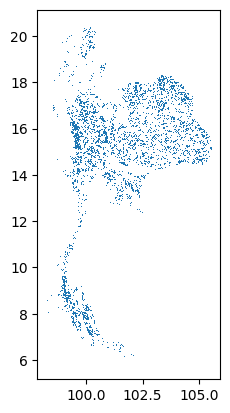

In [18]:
### Polygonized solar ### 

mask = None
with rasterio.Env():
    with rasterio.open('Output_SolarWind\\xr_AVA_solar.nc') as src:
        image = src.read(1) # first band
        results = (
        {'properties': {'raster_val': v}, 'geometry': s}
        for i, (s, v) 
        in enumerate(
            shapes(image, mask=mask, transform=src.transform,connectivity=8)))
        
geoms = list(results)

gpd_polygonized_raster_solar  = gpd.GeoDataFrame.from_features(geoms)
gpd_polygonized_raster_solar.crs = {'init': 'epsg:4326'}
gpd_polygonized_raster_solar= gpd_polygonized_raster_solar.to_crs({'init': 'epsg:3857'})
gpd_polygonized_raster_solar['area'] = gpd_polygonized_raster_solar['geometry'].area / (10**6)
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar.to_crs({'init': 'epsg:4326'})
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar.loc[gpd_polygonized_raster_solar['raster_val'] != 0]
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar.loc[gpd_polygonized_raster_solar['area'] > 0.4]

gpd_polygonized_raster_solar_normal = gpd_polygonized_raster_solar.loc[gpd_polygonized_raster_solar['area'] <= maxarea_solar]
gpd_polygonized_raster_solar_normal.reset_index(inplace=True,drop=True)
gpd_polygonized_raster_solar_large = gpd_polygonized_raster_solar.loc[gpd_polygonized_raster_solar['area'] > maxarea_solar]
gpd_polygonized_raster_solar_large.reset_index(inplace=True,drop=True)

geom = (gpd_polygonized_raster_solar_large['geometry'][0])
slicingsclae = 0.0175
grid = partition(geom, slicingsclae)

buffer = [shapely.geometry.Polygon(poly) for poly in (grid)]

gpd_ref  = gpd.GeoDataFrame(geometry=buffer)
gpd_ref.crs = {'init': 'epsg:4326'}
gpd_ref['center'] = gpd_ref['geometry'].centroid
gpd_ref = gpd_ref.loc[gpd_ref['center'].within(geom)]
gpd_ref.reset_index(inplace=True,drop=True)

for i in range(1,len(gpd_polygonized_raster_solar_large),1):
    geom = (gpd_polygonized_raster_solar_large['geometry'][i])
    grid = partition(geom, slicingsclae)
    buffer = [shapely.geometry.Polygon(poly) for poly in (grid)]
    gpd_buffer  = gpd.GeoDataFrame(geometry=buffer)
    gpd_buffer.crs = {'init': 'epsg:4326'}
    gpd_buffer['center'] = gpd_buffer['geometry'].centroid
    gpd_buffer = gpd_buffer.loc[gpd_buffer['center'].within(geom)]
    gpd_buffer.reset_index(inplace=True,drop=True)
    gpd_ref = gpd_ref.append(gpd_buffer)
    gpd_ref.reset_index(inplace=True,drop=True)


gpd_ref['raster_val'] = 0.09
gpd_ref= gpd_ref.to_crs({'init': 'epsg:3857'})
gpd_ref['area'] = gpd_ref['geometry'].area / (10**6)
gpd_ref= gpd_ref.to_crs({'init': 'epsg:4326'})
gpd_ref = gpd_ref.drop(columns='center')
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar_normal.append(gpd_ref)
gpd_polygonized_raster_solar.reset_index(inplace=True,drop=True)

gpd_polygonized_raster_solar['raster_val'] = 0
gpd_polygonized_raster_solar['raster_val'].loc[gpd_polygonized_raster_solar['area'] < 0.4] = 0
gpd_polygonized_raster_solar['raster_val'].loc[gpd_polygonized_raster_solar['area'] >= 0.4] = 3
gpd_polygonized_raster_solar['center'] = gpd_polygonized_raster_solar['geometry'].centroid
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar.reset_index()
gpd_polygonized_raster_solar = gpd_polygonized_raster_solar.rename(columns={'index':'pol_id_solar'})
print('len of polygons = ', len(gpd_polygonized_raster_solar))

df_xr_final_SI = xr_final_SI['SI_Solar'].to_dataframe()
df_xr_final_SI = df_xr_final_SI.loc[df_xr_final_SI['SI_Solar'] >0]
df_xr_final_SI.reset_index(inplace=True)
df_xr_final_SI = gpd.GeoDataFrame(df_xr_final_SI, geometry =gpd.points_from_xy(df_xr_final_SI['lon'],df_xr_final_SI['lat']))
df_xr_final_SI.crs = {'init': 'epsg:4326'}
df_ref = gpd.sjoin_nearest(df_xr_final_SI,gpd_polygonized_raster_solar,distance_col="distance",how='left')
df_ref= df_ref.drop(columns = ['geometry','index_right','raster_val','area','center','distance','lat','lon'])
df_ref = df_ref.groupby(['pol_id_solar']).agg('mean')

gpd_polygonized_raster_solar['final_SI_Solar'] = (gpd_polygonized_raster_solar['raster_val'] * weight_solar[9]) + df_ref['SI_Solar']
check_weight_solar = check_weight_solar + weight_solar[9]

print('total area for solar = ',gpd_polygonized_raster_solar['area'].sum())
print("Check w solar = ",check_weight_solar)
print(gpd_polygonized_raster_solar)
gpd_polygonized_raster_solar.to_csv('Output_SolarWind\\df_final_SI_Solar.csv',index=False)
gpd_polygonized_raster_solar.plot()